# **Programa Principal**

In [14]:
#!pip install pandas -q
#!pip install matplotlib -q
#!pip install seaborn -q
#!pip install db-sqlite3 -q
#!pip install SQLAlchemy -q
#!pip install requests -q
#!pip install jsonlib -q
#!pip install folium


## 1) Bibliotecas

In [15]:
import pandas as pd
import numpy as np
import folium

## 2) Extração de dados

In [16]:
df_janeiro = pd.read_csv('./dados/focos_mensal_br_202401.csv')
df_fevereiro = pd.read_csv('./dados/focos_mensal_br_202402.csv')
df_marco = pd.read_csv('./dados/focos_mensal_br_202403.csv')
df_abril = pd.read_csv('./dados/focos_mensal_br_202404.csv')
df_maio = pd.read_csv('./dados/focos_mensal_br_202405.csv')
df_junho = pd.read_csv('./dados/focos_mensal_br_202406.csv')

In [17]:
#setando o caminho + arquivos que serão concatenados
path = 'dados/focos_mensal_br_2024'

#concatenar os arquivos csv com o nome igual ao setado em "path"
df_brasil_2024 = pd.concat([pd.read_csv(f"{path}{mes:02}.csv") for mes in range(1,7)])

#exibir a tabela concatenada
df_brasil_2024

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


In [18]:
#mostrar quantidade de celulas x colunas
df_brasil_2024.shape

(983232, 16)

In [19]:
#descrever 
df_brasil_2024.describe()

,lat,lon,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,frp
count,983232.000000,983232.000000,9.832320e+05,983232.000000,983232.0,983232.000000,983232.000000,983232.000000,951407.000000
mean,-9.993129,-53.809391,3.189780e+06,31.827838,33.0,9.495614,0.690434,-21.650540,33.780956
std,8.596091,6.936608,1.611532e+06,16.108001,0.0,104.052397,3.708917,147.580664,57.590815
min,-33.715350,-73.666210,1.100015e+06,11.000000,33.0,-999.000000,0.000000,-999.000000,0.000000
25%,-17.497535,-60.026930,1.400472e+06,14.000000,33.0,5.000000,0.000000,0.210000,3.800000
50%,-11.185035,-56.279550,2.922250e+06,29.000000,33.0,14.000000,0.000000,0.770000,9.400000
75%,-2.304890,-48.093350,5.006903e+06,50.000000,33.0,29.000000,0.000000,1.000000,54.200000
max,5.163930,-34.809400,5.300108e+06,53.000000,33.0,93.000000,252.980000,1.000000,4720.700000


### 2.1. Queimadas 2023

`Tratamento dos nomes das Colunas`

In [20]:
#exibir nome das colunas
df_brasil_2024.columns

Index(['id', 'lat', 'lon', 'data_hora_gmt', 'satelite', 'municipio', 'estado',
       'pais', 'municipio_id', 'estado_id', 'pais_id', 'numero_dias_sem_chuva',
       'precipitacao', 'risco_fogo', 'bioma', 'frp'],
      dtype='object')

In [21]:
#renomear colunas
df_brasil_2024.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)

`Tratamento de Null`

In [22]:
#verificando quais colunas possuem valores nulos
df_brasil_2024.isnull().sum()

id                           0
latitude                     0
longitude                    0
data_hora_gmt                0
satelite                     0
municipio                    0
estado                       0
pais                         0
municipio_id                 0
estado_id                    0
pais_id                      0
numero_dias_sem_chuva        0
precipitacao                 0
risco_fogo                   0
bioma                        1
frp                      31825
dtype: int64

In [23]:
df_brasil_2024.fillna('Desconhecido')

,id,latitude,longitude,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


In [24]:
#remover espaços em branco dos nomes das colunas

df_brasil_2024.columns = df_brasil_2024.columns.str.strip()

#remover espaços em branco dos dados das células

df_brasil_2024 = df_brasil_2024.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df_brasil_2024

,id,latitude,longitude,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,966ed445-fa70-3369-9802-3e74c5765684,-12.5667,-41.4364,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,8,1.38,0.70,Caatinga,76.5
1,0669c14d-7a39-3d98-9f20-23e118fbcf09,-12.5662,-41.4611,2024-01-01 00:06:16,GOES-16,LENÇÓIS,BAHIA,Brasil,2919306,29,33,9,1.73,0.83,Caatinga,81.4
2,53a46800-fa40-3323-9b20-05108d435c24,-18.0629,-57.3721,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,14.42,0.00,Pantanal,59.8
3,d0af560b-c440-3554-a5c6-83fb055304e8,-18.0823,-57.3902,2024-01-01 00:06:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,63.4
4,b509b339-729d-3a30-a7d9-8a6a33398a4f,-18.0823,-57.3902,2024-01-01 00:16:48,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,0,12.93,-999.00,Pantanal,64.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353038,feb4f53b-e202-350c-8f74-7f82fc40cb1d,-19.6805,-57.0351,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,62,0.00,0.84,Pantanal,106.4
353039,7fcb2a72-dd94-33e5-b249-69de261a3faf,-19.6801,-57.0561,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.94,Pantanal,60.7
353040,7d66733d-24fd-3205-967d-17dc67e60fd2,-20.0190,-42.8786,2024-06-30 23:36:57,GOES-16,SÃO DOMINGOS DO PRATA,MINAS GERAIS,Brasil,3161007,31,33,88,0.00,1.00,Mata Atlântica,86.7
353041,defe4e3a-b07b-30a1-9a9c-9e3403ab2967,-19.6604,-57.0379,2024-06-30 23:36:57,GOES-16,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,60,0.00,0.89,Pantanal,68.3


`Exclusão de colunas não utilizadas`

In [25]:
#removendo colunas
df_brasil_2024.drop('frp', axis=1, inplace=True)
df_brasil_2024.drop('id', axis=1, inplace=True)
df_brasil_2024.drop('pais', axis=1, inplace=True)
df_brasil_2024.drop('municipio_id', axis=1, inplace=True)
df_brasil_2024.drop('estado_id', axis=1, inplace=True)
df_brasil_2024.drop('pais_id', axis=1, inplace=True)

`Exclusão de Dados incoerentes`

"Nos downloads de focos do BDQ-Banco de Dados de Queimadas, o atributo "RiscoFogo" dos focos é o valor do Risco de Fogo previsto para o mesmo dia da ocorrência do foco, segundo o método de cálculo descrito em: Método do Cálculo do Risco de Fogo do Programa do INPE. Neste documento você vai notar que os valores são válidos de 0 a 1 e, o número -999 representa valor inválido, normalmente relacionado como área urbana ou corpos d'água, onde não faz sentido calcular o Riso de Fogo."
Disponível em: <https://terrabrasilis.dpi.inpe.br/queimadas/portal/faq/index.html> Pergunta 43

In [26]:
df_brasil_2024.query('risco_fogo != -999', inplace=True)
#df_brasil_2024

## 3) Gráficos

### 3.1. Mapa de calor (Heatmap) de Risco de Fogo

In [27]:
#Diogo
Risk_of_Fire=df_brasil_2024.sort_values(by='risco_fogo',ascending=False)
new_set = Risk_of_Fire.head(25)

In [28]:
#Trasforma valores do dataframe para lista
coordenadas_fogo = new_set[['latitude', 'longitude']].values.tolist()
municipios = new_set[['municipio']].values.tolist()
print(coordenadas_fogo[0:4])
print(municipios[0:4])

[[-14.6424, -45.0794], [2.538, -61.49197], [2.86865, -60.74482], [3.96805, -61.31206]]
[['COCOS'], ['MUCAJAÍ'], ['BOA VISTA'], ['AMAJARI']]


In [29]:
#Utilziando o folium

#Definição de ponto central
F_Mapa = folium.Map([-15.797515,-47.891887],zoom_start=5,control_scale=True)

#Plotagem de marcadores no mapa
for i in range(len(coordenadas_fogo)):
    pontos = coordenadas_fogo[i]
    cid = municipios[i]
    folium.Marker(pontos, popup=cid).add_to(F_Mapa)
F_Mapa



### 3.2. Mapa de precipitação

In [30]:
#Diogo
precipitation_set=df_brasil_2024.sort_values(by='precipitacao',ascending=False)
p_new_set = precipitation_set.head(25)

In [31]:
#Trasforma valores do dataframe para lista
coordenadas_agua = p_new_set[['latitude', 'longitude']].values.tolist()
municipios = p_new_set[['municipio']].values.tolist()
chuva = p_new_set[['precipitacao']].values.tolist()
print(coordenadas_agua[0:4])
print(municipios[0:4])
print(chuva[0:4])

[[-29.50417, -52.48787], [-28.55103, -55.36242], [0.3826, -60.5695], [0.3806, -60.578098]]
[['SINIMBU'], ['SANTO ANTÔNIO DAS MISSÕES'], ['RORAINÓPOLIS'], ['RORAINÓPOLIS']]
[[252.98], [230.9], [157.24], [156.32]]


In [32]:
#Definição de ponto central
P_Mapa = folium.Map([-15.797515,-47.891887],zoom_start=5,control_scale=True)

#Plotagem de marcadores no mapa
for i in range(len(coordenadas_agua)):
    pontos = coordenadas_agua[i]
    cid = municipios[i]
    agua = chuva[i]
    folium.Marker(pontos, popup=(cid,agua)).add_to(P_Mapa)
P_Mapa

### 3.3. Gráfico de Linha para Número de Dias sem Chuva

In [33]:
#Alex

### 3.4. Gráfico de Dispersão (Scatter Plot)

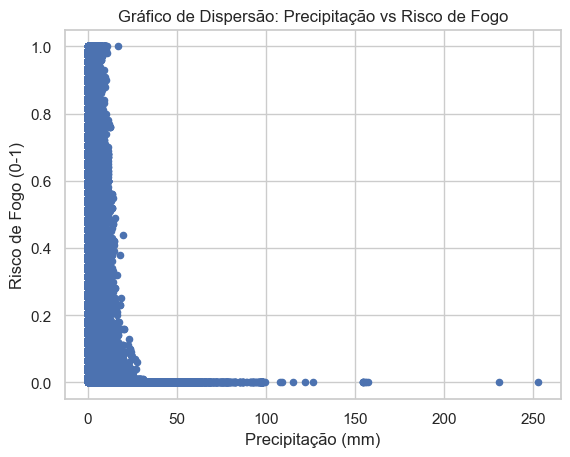

In [34]:
df_brasil_2024.plot(
    kind='scatter', 
    x='precipitacao', 
    y='risco_fogo',
    ylabel='Risco de Fogo (0-1)', 
    xlabel='Precipitação (mm)', 
    title='Gráfico de Dispersão: Precipitação vs Risco de Fogo');

**Explicação**: 
- A precipitação é um fator que influencia significativamente a redução do risco de fogo;
- Quanto maior o nível de precipitação, menor é o risco de fogo e vice-versa;
- Portanto, há uma correlação inversa entre o Risco de fogo e a precipitação

### 3.5. Análise Temporal

In [35]:
# Thiago

### 3.6. Boxplot de Precipitação por Estado/Município:

In [36]:
# Alessandra

### 3.7. Gráfico de Barras Comparativo

DataFrame de Comparação:      estado  numero_dias_sem_chuva  precipitacao  risco_fogo
0      ACRE                  17538       2405.18    0.406864
1   ALAGOAS               -1776602      11080.96    0.801372
2     AMAPÁ                  -8783        470.70    0.087881
3  AMAZONAS                 163449      12687.44    0.256886
4     BAHIA                -316954      31785.13    0.623615




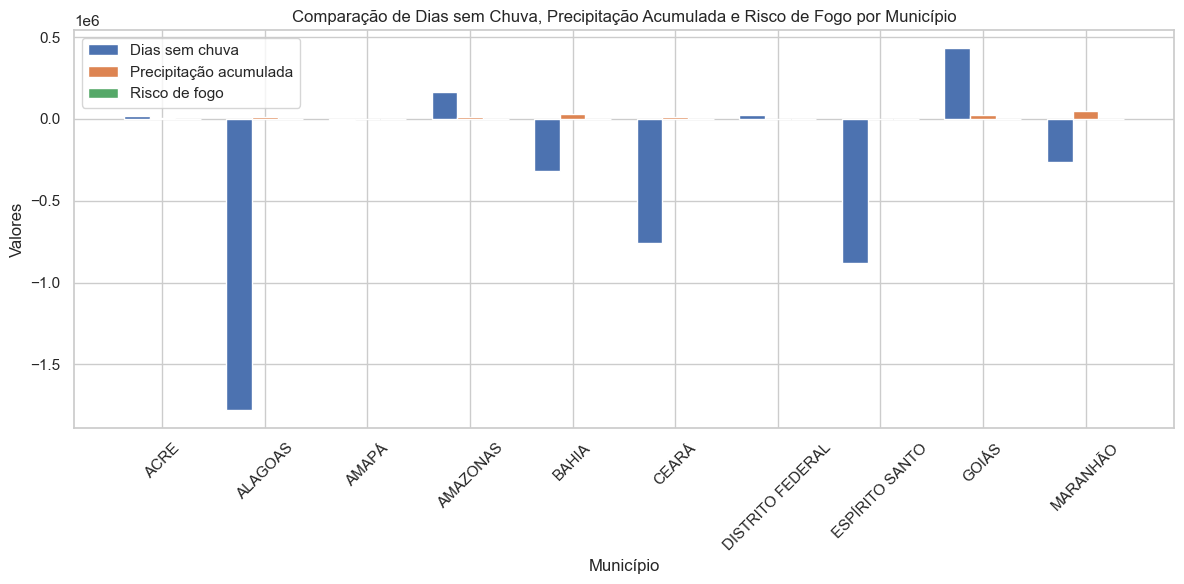

In [43]:
#Diana 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar o estilo do Seaborn
sns.set(style='whitegrid')

# Agrupar os dados por estado
df_comparativo = df_brasil_2024.groupby('estado').agg({
    'numero_dias_sem_chuva': 'sum',  # Somar os dias sem chuva
    'precipitacao': 'sum',           # Somar a precipitação acumulada
    'risco_fogo': 'mean'             # Calcular a média do risco de fogo
}).reset_index()

# Verificar o DataFrame resultante
print("DataFrame de Comparação:", df_comparativo.head())
print("\n")

# Definir o número de estados a serem exibidos
n_estados = min(10, len(df_comparativo))

# Criar uma nova figura
plt.figure(figsize=(12, 6))

# Criar gráfico de barras
bar_width = 0.25
index = np.arange(n_estados)

# Barras para dias sem chuva
plt.bar(index, df_comparativo['numero_dias_sem_chuva'].head(n_estados), bar_width, label='Dias sem chuva')

# Barras para precipitação acumulada
plt.bar(index + bar_width, df_comparativo['precipitacao'].head(n_estados), bar_width, label='Precipitação acumulada')

# Barras para risco de fogo
plt.bar(index + 2 * bar_width, df_comparativo['risco_fogo'].head(n_estados), bar_width, label='Risco de fogo')

# Adicionar título e rótulos
plt.title('Comparação de Dias sem Chuva, Precipitação Acumulada e Risco de Fogo por Município')
plt.xlabel('Município')
plt.ylabel('Valores')
plt.xticks(index + bar_width, df_comparativo['estado'].head(n_estados), rotation=45)
plt.legend()

# Exibir gráfico
plt.tight_layout()
plt.show()

### 3.8. Histogramas

In [38]:
#Thiago

### 3.9. Gráficos de Satélites

In [39]:
#Alessandra